Setup

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.head())
print(df.info())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

Handling missing values

In [2]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])


Encoding Categories that are important

In [3]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')  # remove ID column if present
categorical_cols.remove('Churn')       # keep target separate

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [4]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})


Scaling Numerical Features

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])


In [6]:
X = df.drop(['customerID', 'Churn'], axis=1, errors='ignore')
y = df['Churn']


In [7]:
print(y.value_counts())


Churn
0    5163
1    1869
Name: count, dtype: int64


Exploratory Data Analysis (EDA)

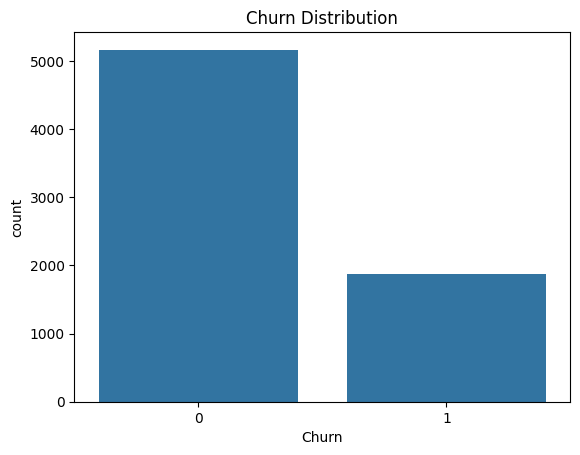

Churn rate: 26.58%


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y)
plt.title('Churn Distribution')
plt.show()

print(f"Churn rate: {y.mean():.2%}")


In [9]:
print(df[num_cols].describe())


             tenure  MonthlyCharges  TotalCharges
count  7.032000e+03    7.032000e+03  7.032000e+03
mean  -1.126643e-16    6.062651e-17 -1.119064e-16
std    1.000071e+00    1.000071e+00  1.000071e+00
min   -1.280248e+00   -1.547283e+00 -9.990692e-01
25%   -9.542963e-01   -9.709769e-01 -8.302488e-01
50%   -1.394171e-01    1.845440e-01 -3.908151e-01
75%    9.199259e-01    8.331482e-01  6.668271e-01
max    1.612573e+00    1.793381e+00  2.824261e+00


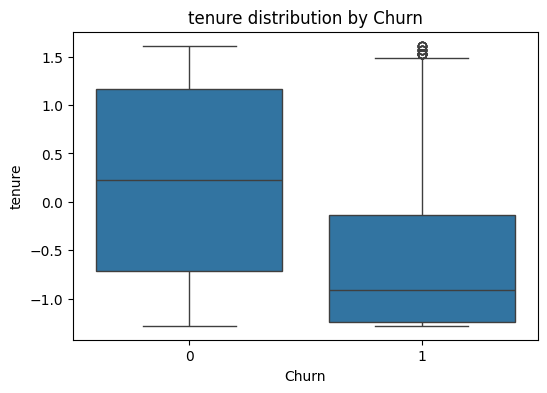

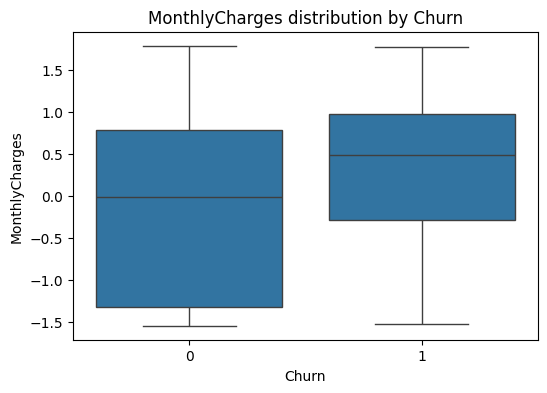

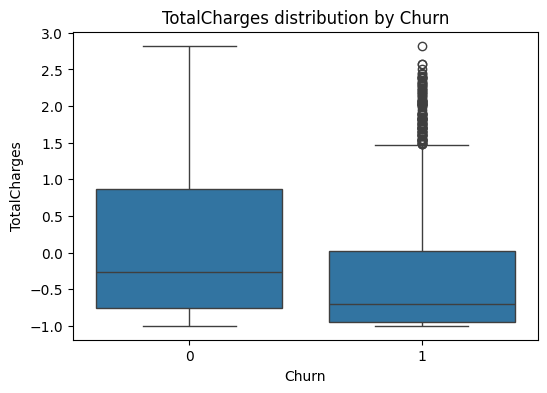

In [10]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=y, y=df[col])
    plt.title(f'{col} distribution by Churn')
    plt.show()


In [13]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()



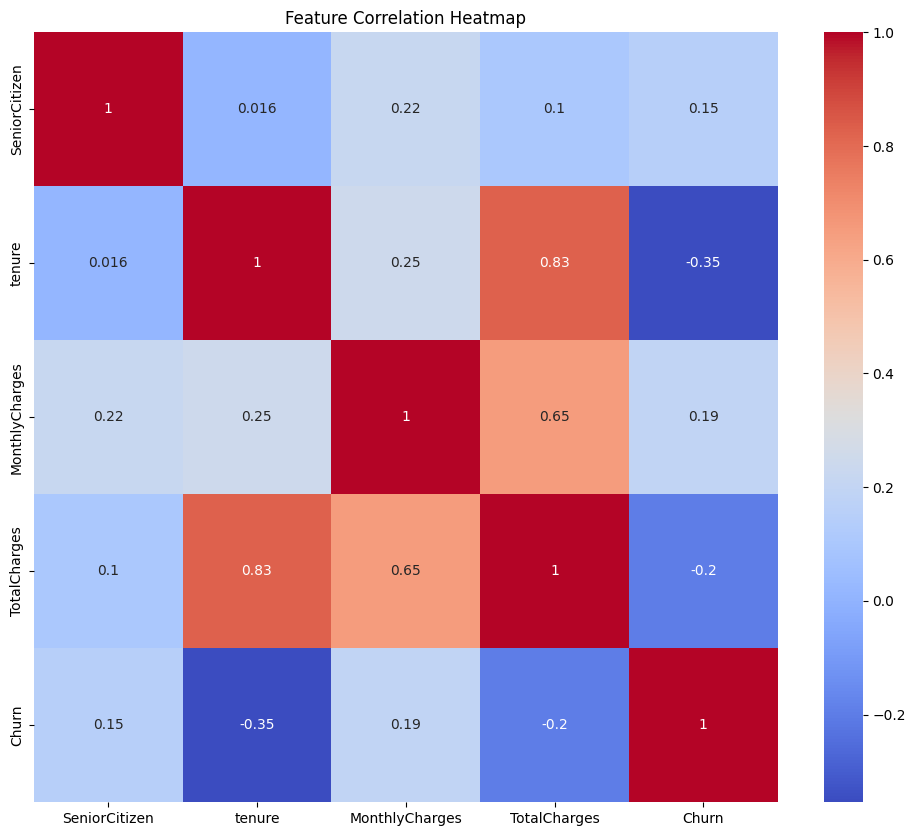

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


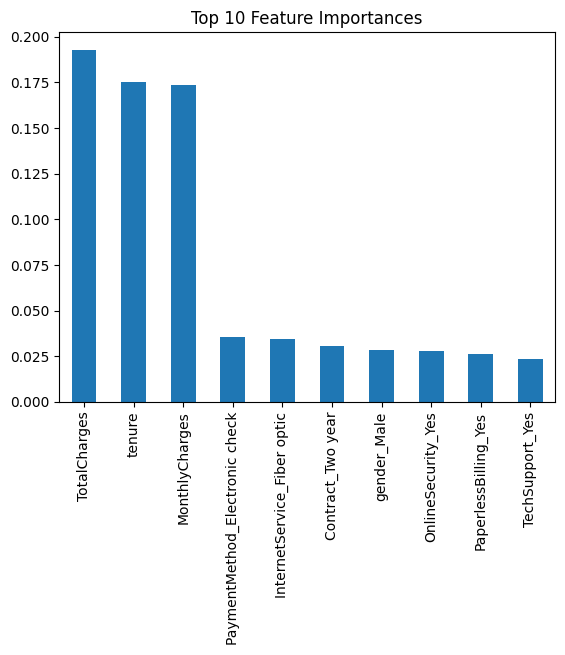

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.show()


Feature Engineering

In [15]:
df['tenure_group'] = pd.cut(df['tenure'],
                            bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12', '12-24', '24-48', '48-60', '60-72'])
# One-hot encode this new feature
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

df['avg_charges_per_month'] = df['TotalCharges'] / (df['tenure'] + 1)  # avoid division by zero



Using RFC and SVM for training

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

# Split data
X = df.drop(['customerID', 'Churn'], axis=1, errors='ignore')
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# SVM (with probability=True for ROC-AUC)
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, svm.predict_proba(X_test)[:,1]))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC: 0.8184730109592019
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1033
           1       0.64      0.40      0.50       374

    accuracy                           0.78      1407
   macro avg       0.73      0.66      0.68      1407
weighted avg       0.77      0.78      0.76      1407

ROC-AUC: 0.8312647861221404


Feature Engineering code

In [17]:
import pandas as pd

# Assuming df is your preprocessed DataFrame with numeric and encoded features

# 1. Create tenure buckets
df['tenure_group'] = pd.cut(df['tenure'],
                           bins=[0, 12, 24, 48, 60, 72],
                           labels=['0-12', '12-24', '24-48', '48-60', '60-72'])

# One-hot encode tenure_group
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

# 2. Create average charges per month feature
df['avg_charges_per_month'] = df['TotalCharges'] / (df['tenure'] + 1)  # +1 to avoid division by zero

# 3. (Optional) If any categorical columns remain unencoded, encode them here
# Example:
# categorical_cols = ['PaymentMethod', 'Contract']  # if any left
# df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 4. Drop customerID if still present
df.drop('customerID', axis=1, inplace=True, errors='ignore')

print("Feature engineering completed. Sample data:")
print(df.head())


Feature engineering completed. Sample data:
   SeniorCitizen    tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0 -1.280248       -1.161694     -0.994194      0        False   
1              0  0.064303       -0.260878     -0.173740      0         True   
2              0 -1.239504       -0.363923     -0.959649      1         True   
3              0  0.512486       -0.747850     -0.195248      0         True   
4              0 -1.239504        0.196178     -0.940457      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  ...  PaymentMethod_Mailed check  \
0                            True  ...                       False   
1                     

Model Training Code

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into train and test sets (stratify to keep churn ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

# Support Vector Machine Classifier
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)[:, 1]

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"SVM ROC-AUC: {roc_auc_score(y_test, y_proba_svm):.4f}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Random Forest ROC-AUC: 0.8183
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1033
           1       0.64      0.40      0.50       374

    accuracy                           0.78      1407
   macro avg       0.73      0.66      0.68      1407
weighted avg       0.77      0.78      0.76      1407

SVM ROC-AUC: 0.8313


Hyperparameter Tuning

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import randint
import pandas as pd

# Assuming 'df' is your preprocessed DataFrame with features and target 'Churn'

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Define parameter distribution for Random Forest (updated max_features)
param_dist_rf = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]  # Removed 'auto'
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Setup RandomizedSearchCV with error_score='raise' for debugging
rand_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,             # number of parameter combinations to try
    cv=5,                  # 5-fold cross-validation
    scoring='roc_auc',     # optimize for ROC-AUC
    random_state=42,
    n_jobs=-1,             # use all CPU cores
    error_score='raise'    # raise exceptions instead of warnings
)

# Fit RandomizedSearchCV on training data
rand_search_rf.fit(X_train, y_train)

# Print best hyperparameters and best cross-validation ROC-AUC score
print("Best Random Forest hyperparameters:", rand_search_rf.best_params_)
print(f"Best Random Forest ROC-AUC (CV): {rand_search_rf.best_score_:.4f}")

# Evaluate the best estimator on the test set
best_rf = rand_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report on Test Set:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest ROC-AUC on Test Set: {roc_auc_score(y_test, y_proba_rf):.4f}")


Best Random Forest hyperparameters: {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 103}
Best Random Forest ROC-AUC (CV): 0.8444
Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1033
           1       0.66      0.45      0.53       374

    accuracy                           0.79      1407
   macro avg       0.74      0.68      0.70      1407
weighted avg       0.78      0.79      0.78      1407

Random Forest ROC-AUC on Test Set: 0.8367


Model Evaluation

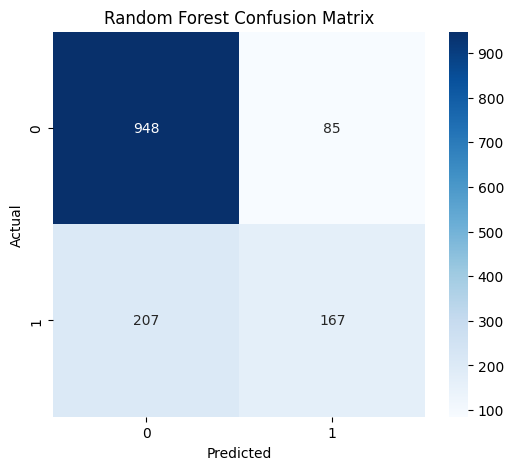

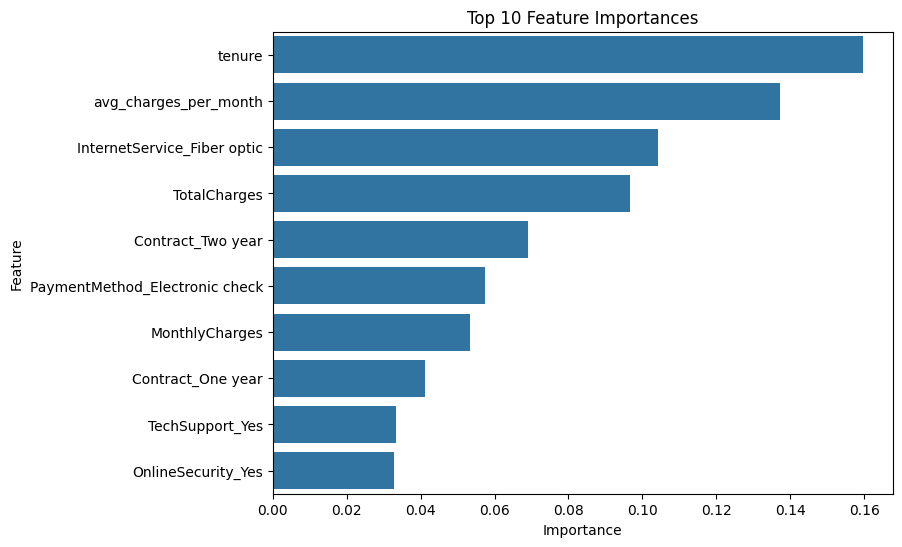

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Feature Importance
importances = best_rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
